## Generative Latent Replay

Experimental code to test generative latent replay on benchmark continual learning problems.

i.e. normalising bottleneck representations and sampling from fitted GMM on latent space.

In [21]:
# ML imports
import torch
import torchvision
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torchinfo import summary
from avalanche.benchmarks.classic import RotatedMNIST, PermutedMNIST

from pathlib import Path

# Local imports
from src import utils, plotting, models

# Continual Learning strategies
from avalanche.training import Naive, Replay, plugins
from src.strategies import LatentReplay, GenerativeLatentReplay

Setup

In [2]:
# Reproducibility
SEED = 43769
utils.set_seed(SEED)

# Reporting
eval_rate = 1

Problem definition

In [3]:
# Number of tasks
n_experiences = 3

# Transform data to format expected by model
transform = utils.get_transforms(resize=244, n_channels=3, normalise=True)
print(transform)

# Load dataset
experiences = PermutedMNIST(
    n_experiences=n_experiences,
    train_transform=transform,
    eval_transform=transform,
    seed=SEED,
    # rotations_list=[0, 60, 300],
)

# Train and test streams
train_stream = experiences.train_stream
test_stream = experiences.test_stream


Compose(
    Resize(size=(244, 244), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Lambda()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


Hyperparameters

In [4]:
# Replays
replay_buffer_size = 6000

# Frozen backbone
freeze_depth = 5
latent_layer_number = freeze_depth * 3 + 1

# SGD hyperparams
sgd_kwargs = {
    "lr": 0.001, #0.1,  # 0.001
    "momentum": 0.9,
    "weight_decay": 0.0005, #l2 regularization
}

strategy_kwargs = {
    "eval_every": eval_rate,
    "train_epochs": 40,
    "train_mb_size": 64,
    "eval_mb_size": 128,
    "device": utils.get_device(),
    "plugins": [
        plugins.EarlyStoppingPlugin(
            patience=eval_rate,
            val_stream_name="train_stream/Task000",
            margin=0.003,  # metric
        )
    ],
}


Building base model

In [5]:
# Model
model_lr = models.alexnet()
model_glr = models.alexnet()
model_naive = models.alexnet()
model_replay = models.alexnet()

Loading Continual Learning strategies for experiments

Training loop

In [ ]:
strategy_lr = LatentReplay(
    model=model_lr,
    rm_sz=replay_buffer_size,
    latent_layer_num=latent_layer_number,
    evaluator=utils.get_eval_plugin("Latent Replay"),
    **strategy_kwargs,
    **sgd_kwargs,
)

#print(strategy_lr.model)
#print(model_lr)
#batch_size = 16
#summary(strategy_lr.model, input_size=(1, *experiences.train_stream[0].dataset[0][0].shape))

# eval_streams=[train_exp] to get validation on current experience (minus replays?)
for train_exp in train_stream:
    strategy_lr.train(train_exp) #, eval_streams=[train_exp])
    strategy_lr.eval(train_stream)

utils.close_loggers(strategy_lr)

In [ ]:
# Loading GLR model
strategy_glr = GenerativeLatentReplay(
    model=model_glr,
    rm_sz=replay_buffer_size,
    latent_layer_num=latent_layer_number,
    evaluator=utils.get_eval_plugin("GLR"),
    **strategy_kwargs,
    **sgd_kwargs,
)

# eval_streams=[train_exp] to get validation on current experience (minus replays?)
for train_exp in train_stream:
    strategy_glr.train(train_exp) #, eval_streams=[train_exp])
    strategy_glr.eval(train_stream)
    utils.save_model(strategy_glr.model, Path("results/GLR"), f"model_{train_exp.current_experience}.pt")

utils.close_loggers(strategy_glr)

In [7]:
# Loading baseline (naive) model
strategy_naive = Naive(
    model=model_naive,
    optimizer=SGD(model_naive.parameters(), **sgd_kwargs),
    evaluator=utils.get_eval_plugin("Naive"),
    **strategy_kwargs,
)

for train_exp in train_stream:
    strategy_naive.train(train_exp, eval_streams=[train_exp])
    strategy_naive.eval(train_stream)

utils.close_loggers(strategy_naive)

c:\Users\jacob\miniconda3\envs\env-glr\lib\site-packages\avalanche\training\plugins\early_stopping.py:112: UserWarning: Metric Top1_Acc_Stream used by the EarlyStopping plugin is not computed yet. EarlyStopping will not be triggered.
  warnings.warn(


In [ ]:
# Loading benchmark (replay) model
strategy_replay = Replay(
    model=model_replay,
    criterion=CrossEntropyLoss(),
    optimizer=SGD(model_replay.parameters(), **sgd_kwargs),
    evaluator=utils.get_eval_plugin("Replay"),
    **strategy_kwargs,
)

for train_exp in train_stream:
    strategy_replay.train(train_exp, eval_streams=[train_exp])
    strategy_replay.eval(train_stream)

utils.close_loggers(strategy_replay)

Plotting

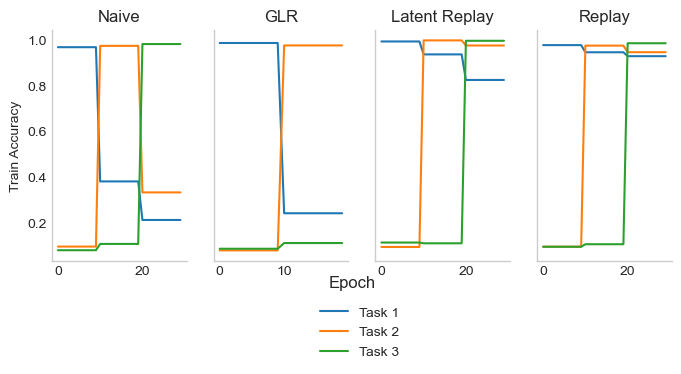

In [18]:
import importlib; importlib.reload(plotting)
plotting.plot_multiple_results()

In [19]:
plotting.results_to_df()

,Final Avg Acc,Final Avg Loss
Naive,0.509333,1.603567
GLR,0.443133,1.951400
Latent Replay,0.933400,0.254600
Replay,0.954800,0.847133
